# Predict mood

In [728]:
import numpy as np
import seaborn as sns
from sklearn import model_selection as ms, linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import warnings
warnings.filterwarnings('ignore')
import shap
shap.initjs()
# Specify the project name
project_name = 'oct_7_pilot'
# Specify if predict the next day
do_predict_next_day_mood = False
next_day_predictors = ['alcohol', 'party']
# Specify if do tining
do_tune_regulatisation = True
do_tune_iterations = False
# Columns to ignore
ignore_cols = ['happy', 'Reels', 'kitchen', 'home', 'stressed', # 'Priežu Vēji',
               'YouTube Education',  'sad',
               'grateful', 'hydrated', 'smoking', 'anxious']
# Specify dates
date_from = 'August 8'
date_to = 'October 8'

### Read training dataset

In [729]:
# Read the prepared training set from CSV
df = pd.read_csv(f'ml_{project_name}.csv')
# Select the desired target
target = 'mood'
not_target = 'next_day_mood'
if do_predict_next_day_mood:
    target = 'next_day_mood'
    not_target = 'mood'
# Specify the desired target
df.rename(columns={target: 'target'}, inplace=True)
df.drop(columns=ignore_cols + [not_target], errors='ignore', inplace=True)
df.head()

,target,sleep,fasting,university,job,movies,gaming,restaurant,mother,father,...,tired,sick,procrastinating,relax,snacking,office,W,L,coffee overdose,unlucky
0,0.25,1.000000,0.0,0.0,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.75,0.634694,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.00,0.634694,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.25,0.450000,0.0,0.0,0.0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0.50,1.000000,0.0,0.0,0.0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Translate scales to binaries

In [730]:
# Specify the threshold
happiness_threshold = 0.2
# Apply the binary function
df['target'] = df['target'].apply(lambda x: 1 if x>happiness_threshold else 0)
# df['sleep'] = df['sleep'].apply(lambda x: 1 if x>happiness_threshold else 0)

### Train-test split

In [731]:
# Splitting the dataset into the training set and test set
X = df.drop(columns=ignore_cols + ['target'], errors='ignore')
y = df['target']
# Split train and test by 80:20 pareto principle
test_size = 0.2
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=test_size, stratify=y)

### Scaler

In [732]:
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

### Logistic Regression

In [733]:
# Hyperparameters
lr_max_iter = 70
regularisation = 1
# Logistic regression model
lr_model = lm.LogisticRegression(penalty="l2", max_iter=lr_max_iter, C=regularisation)
lr_model.fit(x_train, y_train)
# X-validation
folds = 5
lr_model_x_val = ms.cross_val_score(lr_model, x_train, y_train, cv=folds, scoring="accuracy")
lr_model_score = np.mean(lr_model_x_val)
f"Logistic regression classifier accuracy: {lr_model_score:.3%}"

'Logistic regression classifier accuracy: 95.000%'

### Tune regularisation

Best regularization = 12.525


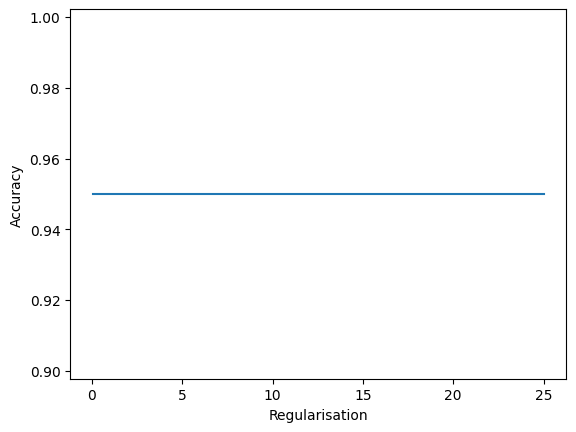

In [734]:
if do_tune_regulatisation:
    # Collect the accuracies
    tuning_accuracies = []
    for i_reg in range(1, 501):
        i_reg *= 0.05
        i_model = lm.LogisticRegression(max_iter=lr_max_iter, C=i_reg)
        tuning_accuracies.append((
            i_reg,
            np.mean(ms.cross_val_score(i_model, x_train, y_train, cv=folds, scoring="accuracy"))
        ))
    # Find the most optimal regularisations
    df_tuning = pd.DataFrame(tuning_accuracies, columns=["regularisation", "accuracy"])
    max_accuracy_indices = df_tuning.index[df_tuning['accuracy'] == df_tuning['accuracy'].max()]
    best_regs = [df_tuning.loc[i, "regularisation"] for i in max_accuracy_indices]
    # Find media
    best_reg = stats.median(best_regs)
    print(f"Best regularization = {best_reg}")
    # Plot tuning results
    plt.plot(df_tuning["regularisation"], df_tuning["accuracy"])
    plt.xlabel("Regularisation")
    plt.ylabel("Accuracy")
    plt.show()

### Tune max iterations

In [735]:
if do_tune_iterations:
    # Collect the accuracies
    tuning_accuracies = []
    for i_max_iter in range(50, 400):
        i_model = lm.LogisticRegression(max_iter=i_max_iter, C=regularisation)
        tuning_accuracies.append((
            i_max_iter,
            np.mean(ms.cross_val_score(i_model, x_train, y_train, cv=folds, scoring="accuracy"))
        ))
    # Find the most optimal regularisation
    df_tuning = pd.DataFrame(tuning_accuracies, columns=["max_iterations", "accuracy"])
    max_acc_index = df_tuning["accuracy"].idxmax()
    # Find median reg
    
    best_reg = df_tuning.loc[max_acc_index, "max_iterations"]
    print(f"Best max iterations = {best_reg}")
    # Plot tuning results
    plt.plot(df_tuning["max_iterations"], df_tuning["accuracy"])
    plt.xlabel("Max iterations")
    plt.ylabel("Accuracy")
    plt.show()

### SHAP

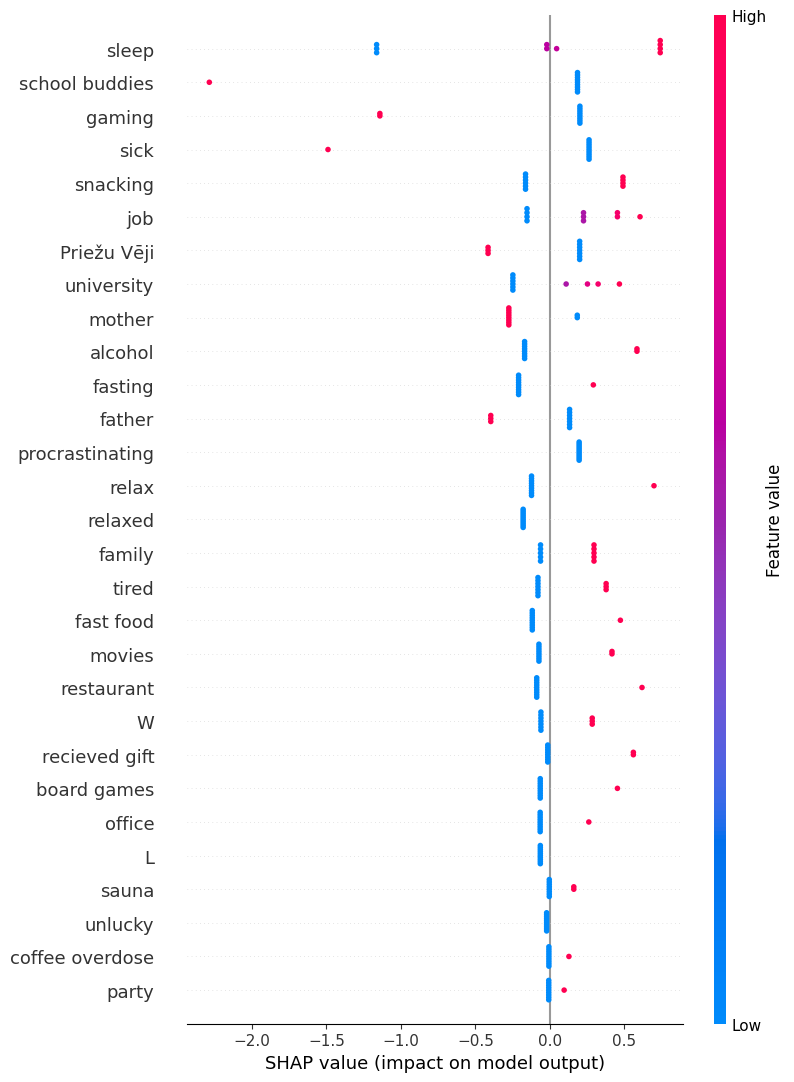

In [736]:
# Get feature names from the Pandas DataFrame columns
feature_names = X.columns.tolist()
# Create a SHAP explainer for the logistic regression model
explainer = shap.Explainer(lr_model, x_train, feature_names=feature_names)
# Calculate SHAP values for a set of instances (e.g., the first 10 instances in X_test)
shap_values = explainer(x_test)
# Summarize the SHAP values for all instances
shap.plots.beeswarm(shap_values, max_display=40)

### Interpret coefficients

In [737]:
# Get the coefficients
coefficients = lr_model.coef_[0]
# Rank features by absolute coefficient value
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: -x[1])
for feature, importance in feature_importance:
    print(f"Feature: {feature}, Coefficient: {importance}")

Feature: sleep, Coefficient: 0.6180024793836115
Feature: university, Coefficient: 0.317885982176557
Feature: alcohol, Coefficient: 0.31493791027910506
Feature: relax, Coefficient: 0.29355937326153253
Feature: relaxed, Coefficient: 0.2915295575269941
Feature: snacking, Coefficient: 0.2832242595502067
Feature: fasting, Coefficient: 0.25910693725458533
Feature: job, Coefficient: 0.2366290690677306
Feature: fast food, Coefficient: 0.2366243012709118
Feature: restaurant, Coefficient: 0.23375564210681452
Feature: movies, Coefficient: 0.17506940092451992
Feature: tired, Coefficient: 0.17384677689446698
Feature: board games, Coefficient: 0.1713603960412124
Feature: L, Coefficient: 0.17013038799185826
Feature: family, Coefficient: 0.13636467207888778
Feature: W, Coefficient: 0.13087937554867166
Feature: office, Coefficient: 0.13060579778741468
Feature: recieved gift, Coefficient: 0.0897349512878533
Feature: unlucky, Coefficient: 0.07662134710299599
Feature: coffee overdose, Coefficient: 0.02931

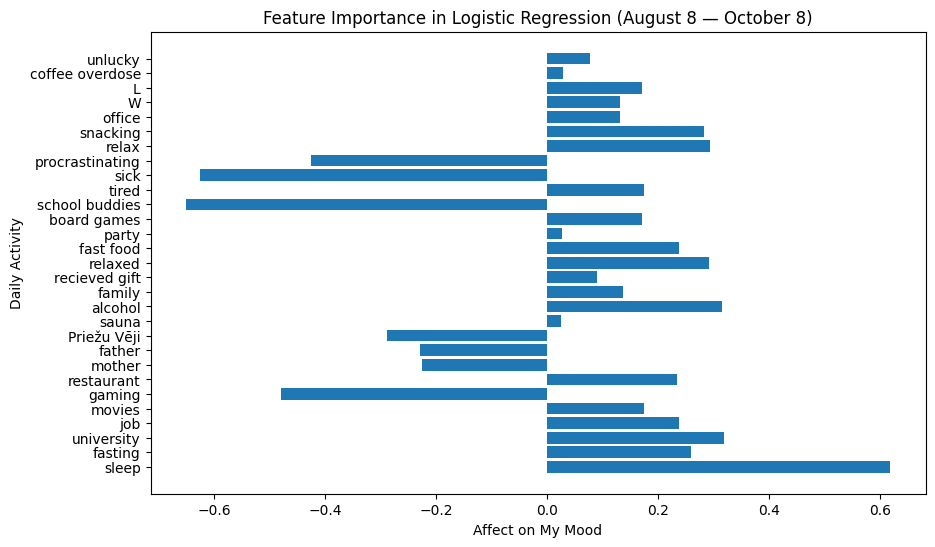

In [738]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Affect on My Mood')
plt.ylabel('Daily Activity')
plt.title(f'Feature Importance in Logistic Regression ({date_from} — {date_to})')
plt.show()

### Final Model Test

In [739]:
final_model = lm.LogisticRegression(max_iter=lr_max_iter, C=regularisation)
final_model.fit(x_train, y_train)
y_test_pred = final_model.predict(x_test)
test_set_correctly_classified = y_test_pred == y_test
test_set_accuracy = np.mean(test_set_correctly_classified)
f"Test set accuracy: {test_set_accuracy:.2%}"

'Test set accuracy: 100.00%'

In [740]:
print(classification_report(y_test, lr_model.predict(x_test)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [741]:
# Calculate the ROC curve
y_pred_proba = final_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = {:.2f})".format(auc_score))
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### Output mood probabilities

In [ ]:
# Predict probabilities of mood
x_pred = final_model.predict_proba(X)
# Add probabilities to the DataFrame
df_prob = pd.DataFrame(x_pred)
df_prob.columns = ['-', 'mood_level']
df['mood_prediction'] = df_prob['mood_level']
# Save answer
df.sort_values(['mood_prediction'], ascending=False, inplace=True)
df.to_csv(f'mood_predictions_{project_name}.csv', index=False)
df.head(2)

,target,sleep,fasting,university,job,mother,father,family,relaxed,tired,mood_prediction
23,1,1.0,0.0,0.0,0.5,1,0,1,1,0,0.996704
38,1,1.0,1.0,0.0,0.0,1,0,0,1,0,0.995920
